In [8]:
from tqdm import tqdm
import numpy as np
from scipy.stats import mode
import matplotlib.pyplot as plt

In [9]:
def generate_hypothesis(n: int = 100, dim: int = 2):

    S = np.random.uniform(size=(n, dim))
    y = np.random.choice((0, 1), size=100, replace=True)

    return S, y

def vectorized_map(map, x, y):

    assert len(x.shape) == len(y.shape) == 2 and x.shape[1] == y.shape[1]
    distances = map(np.expand_dims(y, 0) - np.expand_dims(x, 1), ord=2, axis=-1)

    return distances

class KNN:

    def __init__(self, k, train_x, train_y):

        self.k = k
        self.train_x = train_x
        self.train_y = train_y

    def distance(self, test_x):

        pairwise_distances = vectorized_map(np.linalg.norm, test_x, self.train_x)

        return pairwise_distances

    def predict(self, k=None, test_x=None, precomputed_distances=None):

        assert test_x is not None or precomputed_distances is not None
        if precomputed_distances is not None:
            pairwise_distances = precomputed_distances
        else:
            if len(test_x.shape) == 1:
                test_x = test_x.reshape(-1, self.train_x.shape[1])
            pairwise_distances = self.distance(test_x)

        assert k is not None or self.k is not None
        if k is None:
            k = self.k

        nearest_indices = np.argpartition(pairwise_distances, k)[:, :k]
        nearest_labels = self.train_y[nearest_indices]
        predictions = mode(nearest_labels.T, keepdims=False).mode

        return predictions
        
class Hypothesis:

    def __init__(self, n: int = 100, dim: int = 2, v: int = 3):
    
        self.S, self.y = generate_hypothesis(n=n, dim=dim)
        self.knn = KNN(k=v, train_x=self.S, train_y=self.y)
        self.dim = dim

    def sample(self, n: int = 4000, threshold: float = 0.8):

        xs = np.random.uniform(size=(n, self.dim))
        preds = self.knn.predict(test_x=xs)
        random_labels = np.random.choice((0, 1), size=n)
        labels = np.where(np.random.uniform(size=n) < threshold, preds, random_labels)

        return xs, labels

In [10]:
n, v, dim = 100, 3, 2

h = Hypothesis(n=n, v=v, dim=dim)

linspace = np.linspace(0, 1, num=300).reshape(-1, 1)
axes = np.meshgrid(*[linspace for _ in range(dim)])
xs = np.concatenate([axis.reshape(-1, 1) for axis in axes], axis=1)

preds = h.knn.predict(test_x=xs)

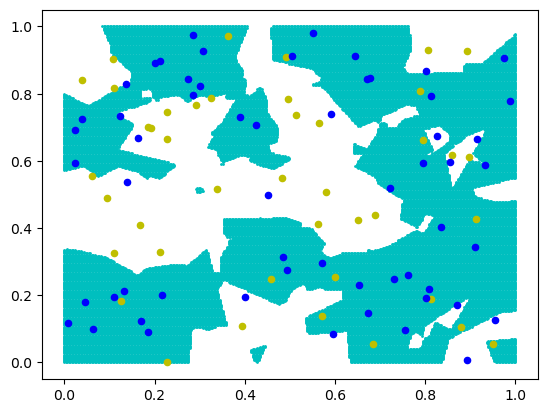

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=1)

axs.scatter(xs[(preds==0).ravel(), 0], xs[(preds==0).ravel(), 1], color='w', s=1)
axs.scatter(xs[(preds==1).ravel(), 0], xs[(preds==1).ravel(), 1], color='c', s=1)
axs.scatter(h.S[(h.y==0).ravel(), 0], h.S[(h.y==0).ravel(), 1], color='y', s=20)
axs.scatter(h.S[(h.y==1).ravel(), 0], h.S[(h.y==1).ravel(), 1], color='b', s=20)

plt.show()

In [13]:
ks = range(1, 50)
ys = list()

gen_errors = np.zeros(shape=(49, 100))

for run in tqdm(range(100)):
    h = Hypothesis(n=n, v=v, dim=dim)
    train_x, train_y = h.sample(n=4000, threshold=0.8)
    test_x, test_y = h.sample(n=1000, threshold=0.8)
    knn = KNN(train_x=train_x, train_y=train_y)
    precomputed_distances = knn.distance(test_x=test_x, top_k=49)
    for k in ks:
        preds = knn.predict(k=k, precomputed_distances=precomputed_distances)
        gen_errors[k-1, run] = np.mean(preds != test_y)
    ys.append(np.mean(gen_errors))

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [03:20<11:50,  9.10s/it]


KeyboardInterrupt: 

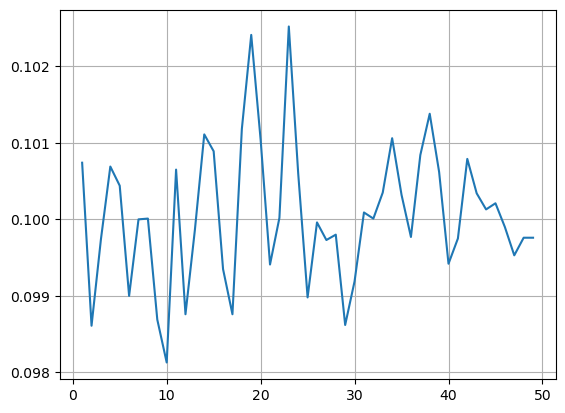

In [ ]:
plt.plot(ks, ys)
plt.grid()